<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Импорт-необходимых-библиотек" data-toc-modified-id="Импорт-необходимых-библиотек-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Импорт необходимых библиотек</a></span></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Импорт необходимых библиотек

In [5]:
import pandas as pd
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit

## Подготовка

In [7]:
data = pd.read_csv(r"C:\Users\nssavinov\Desktop\Пректы практикум\11. Временные ряды\taxi.csv", index_col = [0], parse_dates = [0]) #выполним загрузку данных

data.info()
display(data.head(5))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [8]:
#Выполним ресемплирование 

data = data.resample('1H').sum()

C:\Users\nssavinov\AppData\Local\Temp\ipykernel_12292\1776624123.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data = data.resample('1H').sum()


In [9]:
#Проверим монотонность индекса

print(data.index.is_monotonic_increasing)

True


<div style = "border:solid Chocolate 2px; padding: 40px">

<font color = 'green' size = 4> Результат данного пункта: </font>
    
    - Выгрузили файл
    - Первым делом преобразовали дату в необходимый формат и сделали ее индексом
    - Нашли общее количество заказов за необходимый нам час, т.к. мы должны определить пиковую нагрузку 
    
Переходим к анализу файла

## Анализ

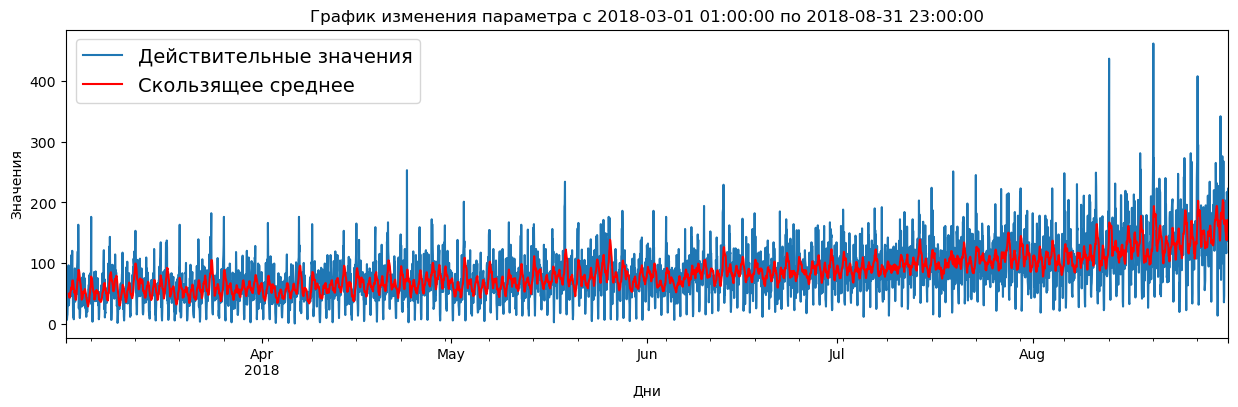

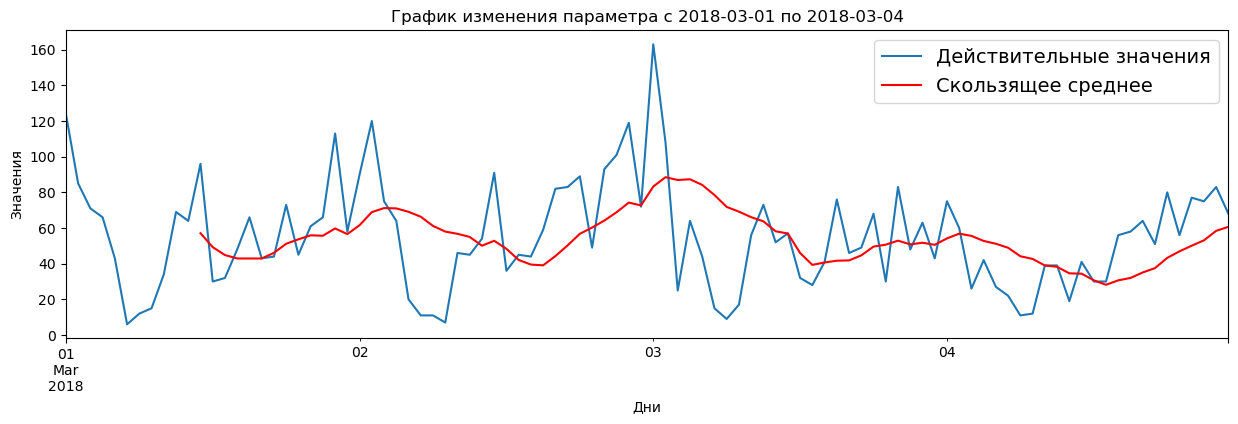

In [12]:
#Изучим полностью график, 

def exploration (df, i, j):
    data = df [i:j]
    data.plot(figsize = (15,4))
    data['num_orders'].rolling(12).mean().plot(color = 'red')
    plt.xlabel('Дни')
    plt.ylabel('Значения')
    plt.title(f'График изменения параметра с {i} по {j}')
    plt.legend(prop={'size': 14}, labels = ['Действительные значения', 'Скользящее среднее'])
    plt.show()

exploration(data, data.index[1], data.index[-1])
exploration(data, '2018-03-01', '2018-03-04')


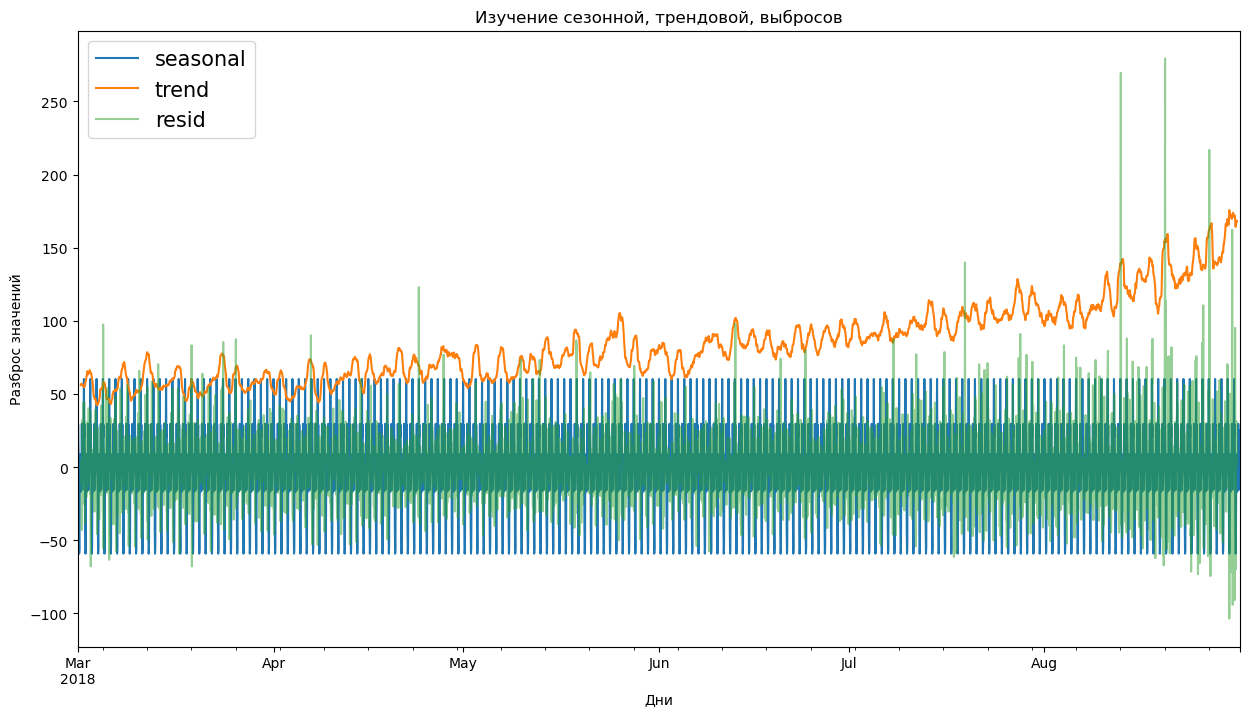

In [14]:
#проведем исследование сезонного и трендового влияния, а также выбросов

sd = seasonal_decompose (data) 
plt.figure (figsize = (15,8))
sd.seasonal.plot()
sd.trend.plot() 
sd.resid.plot(alpha = 0.5)
plt.title('Изучение сезонной, трендовой, выбросов')
plt.legend(prop={'size': 15})
plt.xlabel('Дни')
plt.ylabel('Разброс значений')
plt.show()


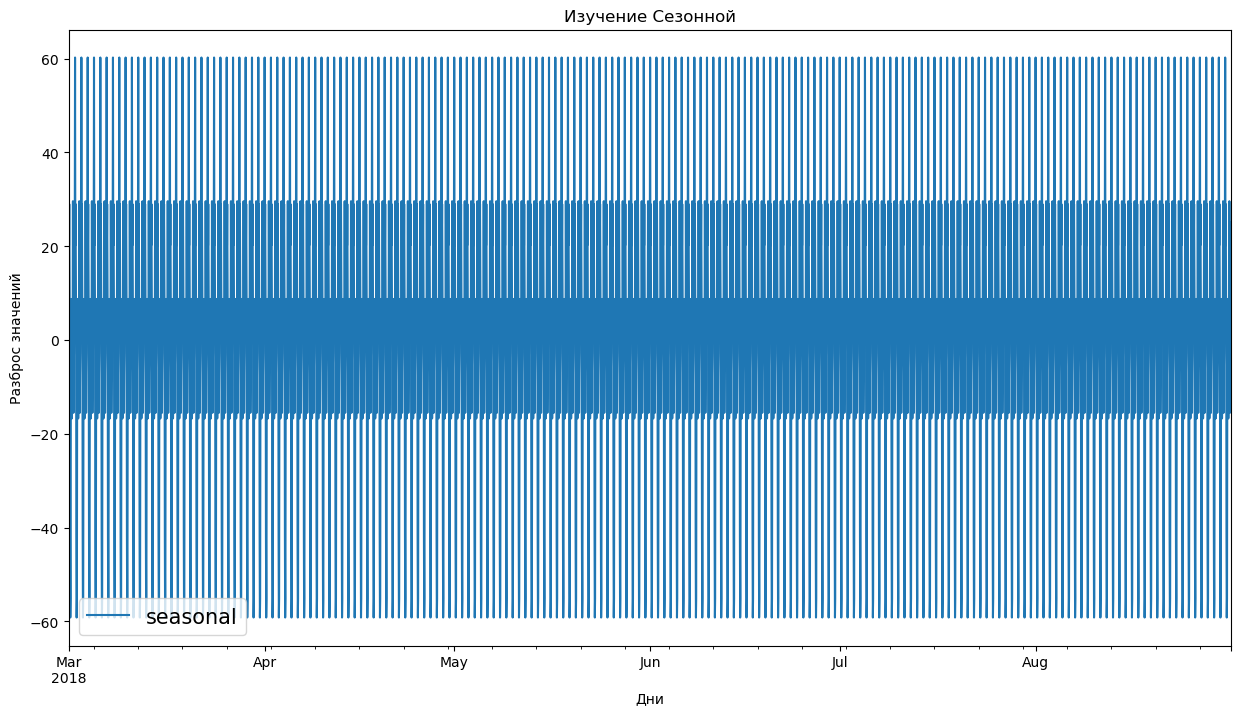

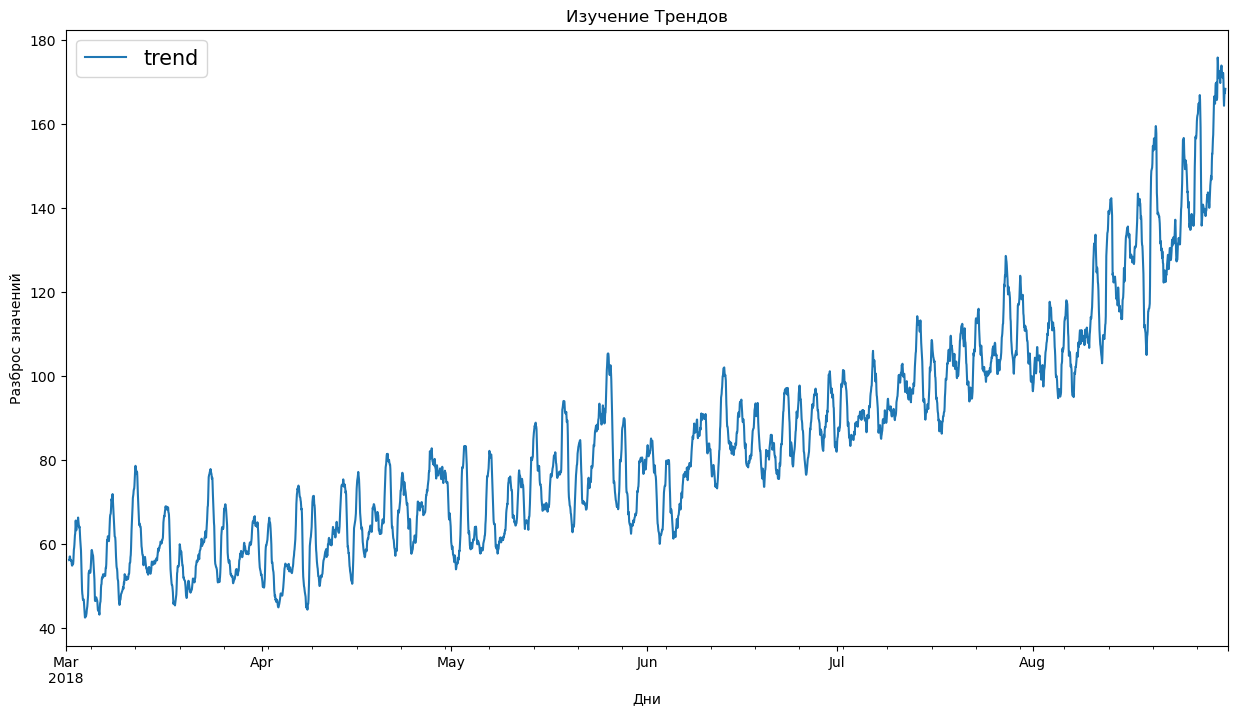

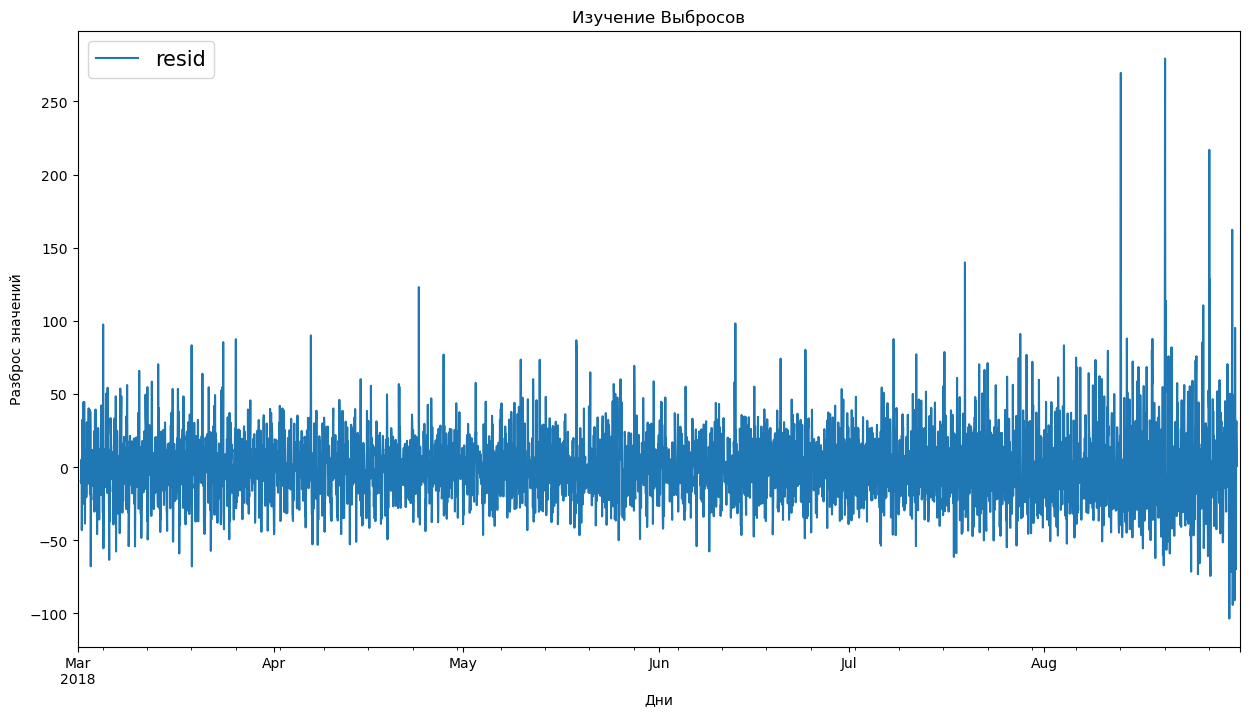

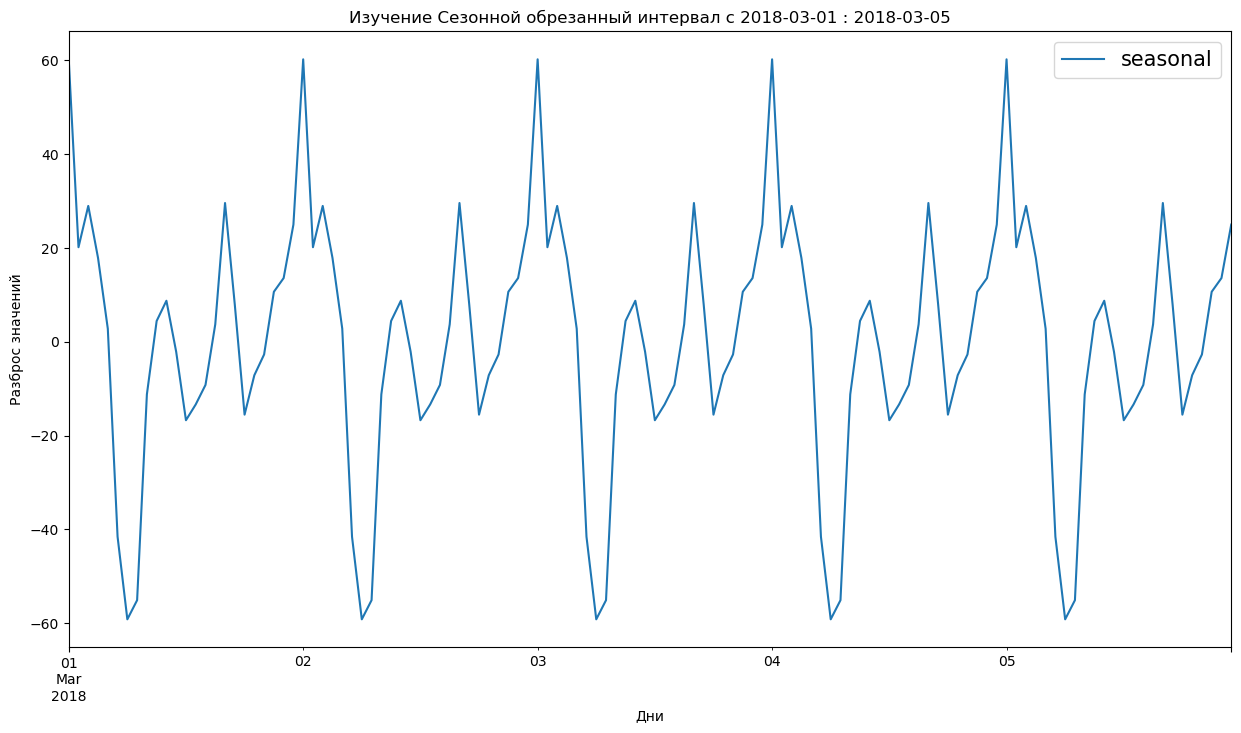

In [18]:
#проведем исследование сезонного и трендового влияния, а также выбросов

season = sd.seasonal
trend = sd.trend
resid = sd.resid

def seasonal(df, i):
    plt.figure (figsize = (15,8))
    df.plot(ax=plt.gca()) 
    plt.title(f'Изучение {i}')
    plt.legend(prop={'size': 15})
    plt.xlabel('Дни')
    plt.ylabel('Разброс значений')
    plt.show()

seasonal(season, 'Сезонной')
seasonal(trend, 'Трендов')
seasonal(resid, 'Выбросов')
seasonal(season['2018-03-01':'2018-03-05'], 'Сезонной обрезанный интервал с 2018-03-01 : 2018-03-05')

<div style = "border:solid Chocolate 2px; padding: 40px">

<font color = 'green' size = 4> Результат данного пункта: </font>
    
    - изучено общее поведение графика. Вывод: данные колеблются в определенных интервалах и имеют восходящий тренд, похоже на стационарных стахостический процесс 
    - изучено на дневном интервале распределение графика. Вывод: к полуночи пользовательская активность увеличивается
    - изучено распределение сезонного/трендового/выбросов графики. Вывод: имеет сезонную активность, значения меняются от -50 до 50. Имеет восходящий тренд, - лучше всего предскажется линейной регрессией. Выбросы -  на всем интервале времени. 
    - период сезонности = 1 сутки, важный признак 1 час

## Обучение

In [29]:
# Наполним датасет фичами

# Дополним как основной фичей от которой зависит кол-во заказов: час и дата 

def prepearing (data, max_lag = 24, level_rolling = 24):
    #data['month'] = data.index.month 
    #data['day'] = data.index.day
    #data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for i in range(1, max_lag+1):
        data[f'lag_{i}'] = data['num_orders'].shift(i)
        
    data[f'rolling_data_mean_{level_rolling}'] = data['num_orders'].shift().rolling(level_rolling).mean()
    
    #data['rest'] = data['num_orders'].shift() - data['num_orders'].shift(2)

    return data

In [37]:
prepearing(data, 168, 168)
data = data.dropna()
data.head()

C:\Users\nssavinov\AppData\Local\Temp\ipykernel_12292\719200206.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'lag_{i}'] = data['num_orders'].shift(i)
C:\Users\nssavinov\AppData\Local\Temp\ipykernel_12292\719200206.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'lag_{i}'] = data['num_orders'].shift(i)
C:\Users\nssavinov\AppData\Local\Temp\ipykernel_12292\719200206.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor pe

,num_orders,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,...,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,rolling_data_mean_168
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-08 00:00:00,143,0,94.0,127.0,108.0,76.0,50.0,99.0,48.0,46.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,54.226190
2018-03-08 01:00:00,78,1,143.0,94.0,127.0,108.0,76.0,50.0,99.0,48.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,54.339286
2018-03-08 02:00:00,65,2,78.0,143.0,94.0,127.0,108.0,76.0,50.0,99.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,54.297619
2018-03-08 03:00:00,68,3,65.0,78.0,143.0,94.0,127.0,108.0,76.0,50.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,54.261905
2018-03-08 04:00:00,60,4,68.0,65.0,78.0,143.0,94.0,127.0,108.0,76.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,54.273810


In [41]:
#Подготовим выборки тестовые и трейновые 
X = data.drop(columns = 'num_orders', axis = 1)
y = data['num_orders']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = False, test_size = 0.1)

#Check it 

print('размер трейн фичи', X_train.shape)
print('размер трейн таргет', y_train.shape)
print('размер тест фичи', X_test.shape)
print('размер тест таргет', y_test.shape)
print('')
print('максимальный индекс трейн', X_train.index.max())
print('минимальный индекс тест', X_test.index.min())

размер трейн фичи (3823, 170)
размер трейн таргет (3823,)
размер тест фичи (425, 170)
размер тест таргет (425,)

максимальный индекс трейн 2018-08-14 06:00:00
минимальный индекс тест 2018-08-14 07:00:00


In [43]:
pipeline = Pipeline(
    [
        ('model', DecisionTreeRegressor())
    ])

params = [
    {
        'model': [DecisionTreeRegressor()],
        'model__max_depth': range(1, 20, 4),
        'model__min_samples_split': range(2, 20, 4),
        'model__min_samples_leaf': range(1, 20, 4)
    },
    {
        'model': [RandomForestRegressor()],
        'model__max_depth': range(1, 20, 3),
        'model__min_samples_split': range(2, 20, 4),
        'model__min_samples_leaf': range(1, 20, 4)
    },
    {
        'model': [CatBoostRegressor()],
        'model__depth': range(1, 10, 3)
    }
    ]

rs = RandomizedSearchCV(estimator = pipeline,
                       param_distributions = params,
                       scoring = 'neg_root_mean_squared_error',
                       n_jobs = -1,
                       cv = TimeSeriesSplit(n_splits=5, test_size=int(len(X_train) * 0.1)),
                       n_iter = 15, #количество варинатов
                       random_state = 12345)

rs.fit(X_train, y_train)

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=382),
                   estimator=Pipeline(steps=[('model',
                                              DecisionTreeRegressor())]),
                   n_iter=15, n_jobs=-1,
                   param_distributions=[{'model': [DecisionTreeRegressor()],
                                         'model__max_depth': range(1, 20, 4),
                                         'model__min_samples_leaf': range(1, 20, 4),
                                         'model__min_samples_split': range(2, 20, 4)},
                                        {'model': [RandomForestRegressor()],
                                         'model__max_depth': range(1, 20, 3),
                                         'model__min_samples_leaf': range(1, 20, 4),
                                         'model__min_samples_split': range(2, 20, 4)},
                                        {'model': [<catboost.core.CatBoostRegressor object at 0x00000250A6675B80>],
                                         'model__depth': range(1, 10, 3)}],
                   random_state=12345, scoring='neg_root_mean_squared_error')

In [49]:
print(f'Лучшая модель - {rs.best_estimator_}')
print(f'Лучшая метрика кросс-валидация = {rs.best_score_ * (-1)}')

Лучшая модель - Pipeline(steps=[('model',
                 RandomForestRegressor(max_depth=13, min_samples_leaf=9,
                                       min_samples_split=14))])
Лучшая метрика кросс-валидация = 24.00721446270996


In [50]:
best_model = rs.best_estimator_

y_train_predict = best_model.predict(X_train)

print(f'RMSE on train dataset = {mean_squared_error(y_train, y_train_predict) ** 0.5}')

RMSE on train dataset = 14.491709460523195


<div style = "border:solid Chocolate 2px; padding: 40px">

<font color = 'green' size = 4> Результат данного пункта: </font>
    
    - изучено общее 3 модели:  Дерево решений, случайный лес и катбуст. Лучшей на кросс валидации оказалась модель дерева решений с определенным гиперпараметрами. 
    - применено 15 итераций для поиска наилучших параметров и TimeSeriesSplit для кросс-валидации
    - Забили лучшую модель в best_model, будем использовать для тестирования

## Тестирование

Проведем анализ на тестовой выборке: 

In [59]:
y_test_predict = best_model.predict(X_test)

print(f'RMSE on train dataset = {mean_squared_error(y_test, y_test_predict) ** 0.5}')

RMSE on train dataset = 39.05102867798598


<div style = "border:solid Chocolate 2px; padding: 40px">

<font color = 'green' size = 4> Результат данного пункта: </font>
    
    - Подобранная модель показала метрику RMSE = 39.6, что проходит по ограничению 